## Importation des libraries et du Drive

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')

file_dir = "./data/"

# Première Analyse des données

### Données à Température fixée

In [3]:
def read_t(t,root="./", str_check=False):
  if not str_check :
    data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
  else :
    data = pickle.load(open(root+f'Ising2DFM_reSample_L40_T={t}.pkl','rb'))
  return np.unpackbits(data).astype(int).reshape(-1,1600)

In [4]:
data_tmp = read_t(3.0, file_dir)
data_tmp.shape

(10000, 1600)

In [5]:
data_tmp[0, :].reshape(40, 40).shape

(40, 40)

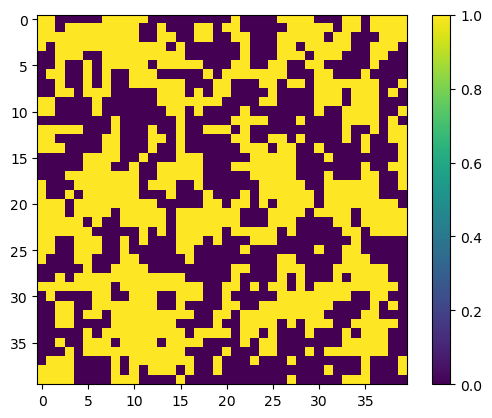

In [6]:
plt.imshow(data_tmp[300, :].reshape(40, 40))
plt.colorbar()

### Analyse du fichier de données totale

In [7]:
data_all = read_t("All", file_dir, True)
data_label = pickle.load(open(file_dir+f'Ising2DFM_reSample_L40_T=All_labels.pkl','rb'))
# print(data_all.shape)
print(data_label.shape)

(160000,)


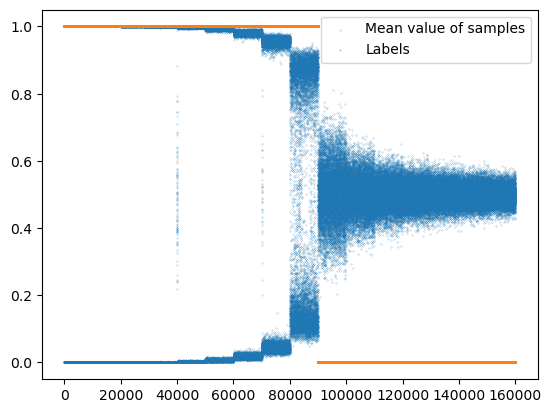

In [8]:
plt.scatter(range(160000), data_all.mean(axis=1), s=.02, label="Mean value of samples")
plt.scatter(range(160000), data_label, s=.1, label="Labels")
plt.legend()

### Concatenation des données et Creation des Labels

In [9]:
nom_temp = np.arange(0.25, 4.25, 0.25)

tot_data = np.empty((0,40,40))
tot_label = np.empty(0)

for T in nom_temp :
  tmp = read_t(T, file_dir)
  tot_data = np.concatenate((tot_data, tmp.reshape(tmp.shape[0], 40, 40)))
  tot_label = np.concatenate((tot_label, T*np.ones(tmp.shape[0])))

In [10]:
tot_data.reshape(tot_data.shape[0], 40*40).mean(axis=1).shape

(160000,)

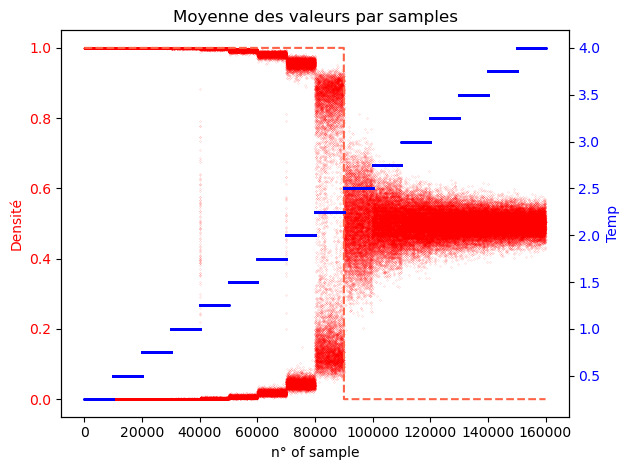

In [11]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('n° of sample')
ax1.set_ylabel('Densité', color="red")
ax1.scatter(range(160000), tot_data.reshape(tot_data.shape[0], 40*40).mean(axis=1), s=.005, label="Mean value of samples", c="r")
ax1.plot(range(160000), data_label, "--", label="Labels", c='tomato')
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx()

ax2.set_ylabel('Temp', color="b")
ax2.scatter(range(160000), tot_label, s=.1, label="Temps", c="b")
ax2.tick_params(axis='y', labelcolor="b")

ax1.set_title("Moyenne des valeurs par samples")

fig.tight_layout()
plt.show()

In [12]:
tot_data_sym = 2*np.abs(tot_data.reshape(tot_data.shape[0], 40*40).mean(axis=1) - 0.5)
tot_data_sym.shape

(160000,)

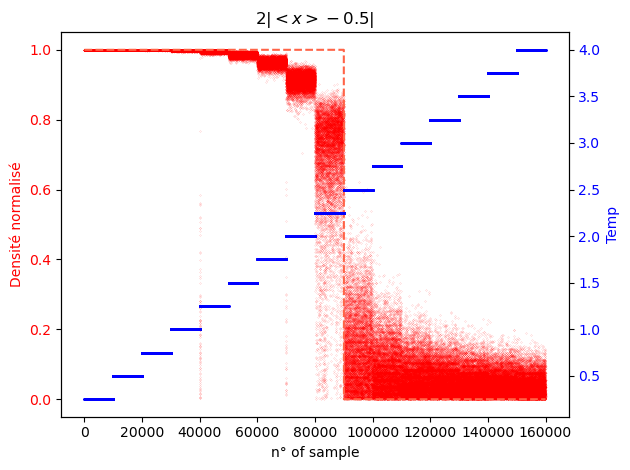

In [13]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('n° of sample')
ax1.set_ylabel('Densité normalisé', color="red")
ax1.scatter(range(160000), tot_data_sym, s=.005, label="Mean value of samples", c="r")
ax1.plot(range(160000), data_label, "--", label="Labels", c='tomato')
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx()

ax2.set_ylabel('Temp', color="b")
ax2.scatter(range(160000), tot_label, s=.1, label="Temps", c="b")
ax2.tick_params(axis='y', labelcolor="b")

ax1.set_title(r'$2 |<x> - 0.5|$')

fig.tight_layout()
plt.show()

# Model naïf : Linear Regression sur toutes les données

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [15]:
flattened_data = tot_data.reshape(tot_data.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(flattened_data, tot_label, test_size=0.2, random_state=42)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [16]:
predictions = linear_model.predict(X_test)
mse = mean_squared_error(y_test,predictions)
mse

1.3398657822606181

## Linear Regression sur la moyenne de Spin Up

In [17]:
tot_data_sym_dim = np.c_[tot_data_sym.reshape(-1, 1), (tot_data_sym.reshape(-1, 1))**2, (tot_data_sym.reshape(-1, 1))**3]
tot_data_sym_dim.shape

(160000, 3)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(tot_data_sym_dim, tot_label, test_size=0.2, random_state=42)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [19]:
predictions = linear_model.predict(X_test)
mse = mean_squared_error(y_test,predictions)
print(mse)

0.17724389788299544


In [20]:
xnew = np.linspace(0, 1, 50)
xnew_dim = np.c_[xnew.reshape(-1, 1), (xnew.reshape(-1, 1))**2, (xnew.reshape(-1, 1))**3]

ynew = linear_model.predict(xnew_dim)

Text(0.5, 0, '$2 |<x> - 0.5|$')

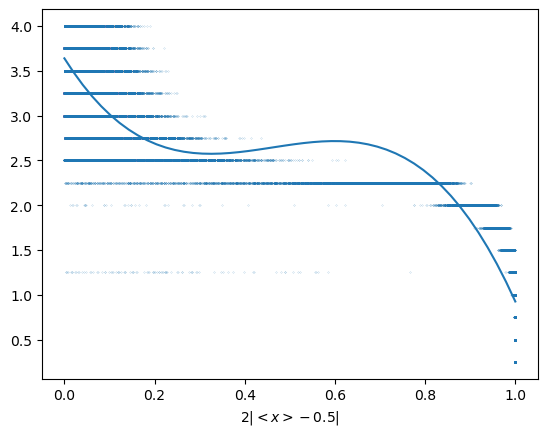

In [21]:
plt.scatter(tot_data_sym, tot_label, s=.01, label="Samples")
plt.plot(xnew, ynew, label="Linear regression")
plt.xlabel(r'$2 |<x> - 0.5|$')

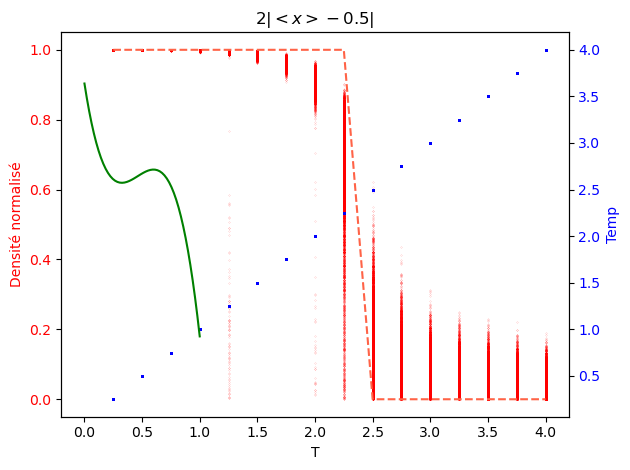

In [22]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('T')
ax1.set_ylabel('Densité normalisé', color="red")
ax1.scatter(tot_label, tot_data_sym, s=.005, label="Mean value of samples", c="r")
ax1.plot(tot_label, data_label, "--", label="Labels", c='tomato')
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx()

ax2.set_ylabel('Temp', color="b")
ax2.scatter(tot_label, tot_label, s=.1, label="Temps", c="b")
ax2.plot(xnew, ynew, c='g')
ax2.tick_params(axis='y', labelcolor="b")

ax1.set_title(r'$2 |<x> - 0.5|$')

fig.tight_layout()
plt.show()

## SGD Training

In [23]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(tot_data_sym.reshape(-1, 1), tot_label)

xnew = np.linspace(0, 1, 50)
ynew = sgd_reg.predict(xnew.reshape(-1, 1))

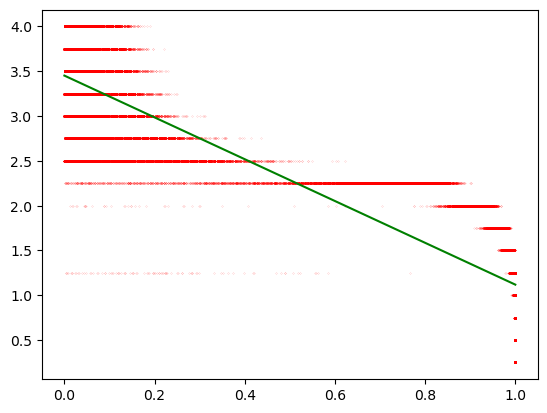

In [24]:
plt.scatter(tot_data_sym, tot_label, s=.005, label="Mean value of samples", c="r")
plt.plot(xnew, ynew, c='g')

### ElasticNet

In [25]:

X_train, X_test, y_train, y_test = train_test_split(np.vander(tot_data_sym, 8), tot_label, test_size=0.2, random_state=42)

In [26]:
from sklearn.linear_model import ElasticNetCV

# Define the ElasticNetCV model
elastic_net = ElasticNetCV(cv=5)

# Fit the model to your data
lasso_model.fit(X_train, y_train)

# Predict on the test set
predictions = lasso_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, predictions)
print(mse)

NameError: name 'lasso_model' is not defined

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

# Create the pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=4)),
    ('scaler', StandardScaler())
])

# Apply the pipeline to your data
X_train, X_test, y_train, y_test = train_test_split(tot_data_sym.reshape(-1, 1), tot_label, test_size=0.2, random_state=42)
X_train_poly_scaled = pipeline.fit_transform(X_train)
X_test_poly_scaled = pipeline.transform(X_test)

# Define the ElasticNetCV model
lasso_model = LassoCV(cv=5, max_iter=10000)

# Fit the model to your data
lasso_model.fit(X_train_poly_scaled, y_train)

# Predict on the test set
predictions = lasso_model.predict(X_test_poly_scaled)

# Calculate the mean squared error
mse = mean_squared_error(y_test, predictions)
print(mse)

0.17340701840544404


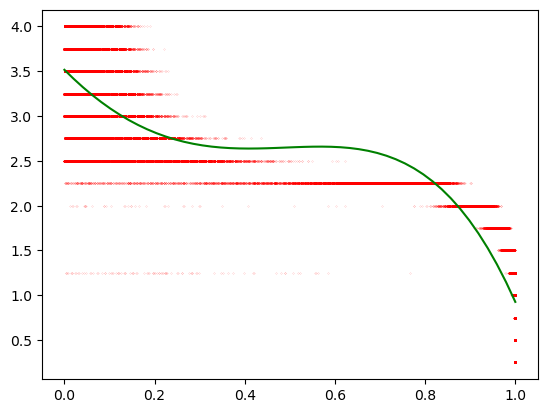

In [28]:
plt.scatter(tot_data_sym, tot_label, s=.005, label="Mean value of samples", c="r")
xnew = np.linspace(0, 1, 50)
ynew = lasso_model.predict(pipeline.transform(xnew.reshape(-1, 1)))
plt.plot(xnew, ynew, c='g')


In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tot_data_sym.reshape(-1,1), tot_label, test_size=0.2, random_state=42)

# Create the random forest regressor
forest_model = RandomForestRegressor(max_depth=5)

# Fit the model to the training data
forest_model.fit(X_train, y_train)

# Predict on the test data
predictions = forest_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, predictions)
print("mse:", mse)


mse: 0.10819291694689648


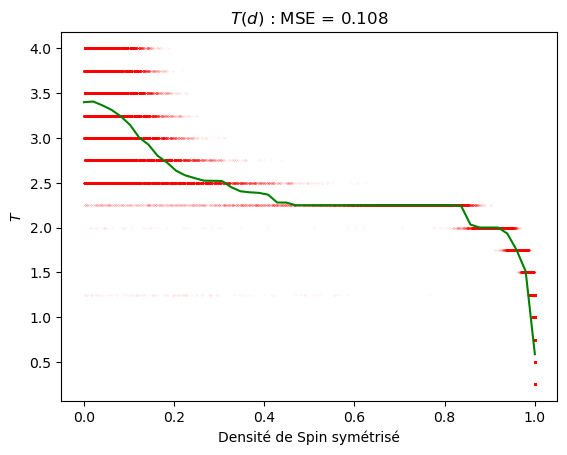

In [32]:
plt.scatter(tot_data_sym, tot_label, s=.001, label="Mean value of samples", c="r")
xnew = np.linspace(0, 1, 50)
ynew = forest_model.predict(xnew.reshape(-1, 1))
plt.plot(xnew, ynew, c='g')
plt.ylabel(r"$T$")
plt.xlabel('Densité de Spin symétrisé')
plt.title(f"$T(d)$ : MSE = {mse:.3f}")
plt.savefig("forest.png", dpi=300)

(160000,) (160000,)


ValueError: List of violinplot statistics and `positions` values must have the same length

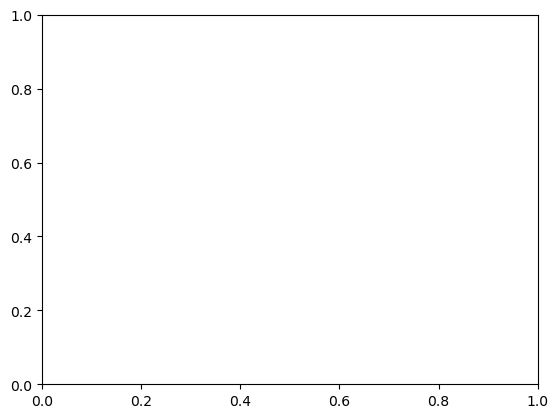

In [59]:
print(tot_data_sym.shape, tot_label.shape)
plt.violinplot(tot_data_sym.reshape(16, 10000), np.linspace(0.25, 4, 16), vert=False)

<AxesSubplot:>

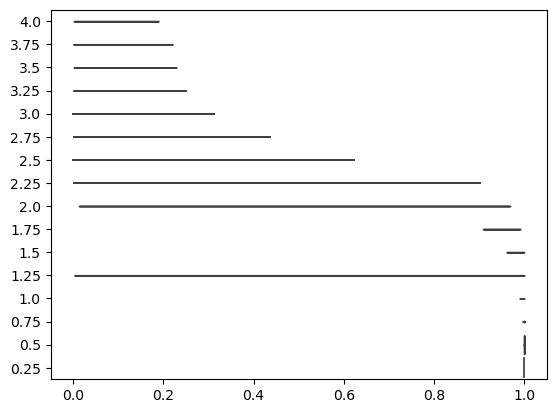

In [49]:
import seaborn as sns

sns.violinplot(y=tot_label, x=tot_data_sym, orient='h', inner=None, order=nom_temp[::-1], cut=0, density_norm="area")

## Test Anatole

In [89]:
import numpy as np

mean_values = []
variance_values = []

for label in np.unique(tot_label):
    data_subset = tot_data_sym[tot_label == label]
    mean = np.mean(data_subset)
    variance = np.var(data_subset)
    mean_values.append(mean)
    variance_values.append(variance)

mean_values = np.array(mean_values)
variance_values = np.array(variance_values)

print("Unique labels:", np.unique(tot_label))
print("Mean values:", mean_values)
print("Variance values:", variance_values)


Unique labels: [0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5
 3.75 4.  ]
Mean values: [1.         0.99999975 0.99994875 0.99926525 0.988936   0.98646962
 0.96399    0.90894263 0.6792085  0.13901638 0.087678   0.06525775
 0.055608   0.049606   0.04428975 0.04030325]
Variance values: [0.00000000e+00 3.12437500e-10 6.61234375e-08 1.00482994e-06
 5.69289697e-03 2.56162961e-05 9.60927125e-05 2.47306336e-03
 2.52409598e-02 1.04490598e-02 4.36271582e-03 2.44247169e-03
 1.71854284e-03 1.36926226e-03 1.10997492e-03 9.30158039e-04]


In [94]:
import pandas as pd

data = {'Temperature': np.unique(tot_label), 'Mean': mean_values, 'Variance': variance_values}
df = pd.DataFrame(data)
display(df)


,Temperature,Mean,Variance
0,0.25,1.000000,0.000000e+00
1,0.50,1.000000,3.124375e-10
2,0.75,0.999949,6.612344e-08
3,1.00,0.999265,1.004830e-06
4,1.25,0.988936,5.692897e-03
5,1.50,0.986470,2.561630e-05
6,1.75,0.963990,9.609271e-05
7,2.00,0.908943,2.473063e-03
8,2.25,0.679208,2.524096e-02
9,2.50,0.139016,1.044906e-02
